# David Kartchner
# Generative Adversarial Networks

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

# Global variables

batch_size = 128
z_dim = 100



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Define Functions

In [3]:
def linear( in_var, output_size, name="linear", stddev=0.02, bias_val=0.0 ):
    shape = in_var.get_shape().as_list()

    with tf.variable_scope( name ):
        W = tf.get_variable( "W", [shape[1], output_size], tf.float32,
                              tf.random_normal_initializer( stddev=stddev ) )
        b = tf.get_variable( "b", [output_size],
                             initializer=tf.constant_initializer( bias_val ))

        return tf.matmul( in_var, W ) + b

def lrelu( x, leak=0.2, name="lrelu" ):
    return tf.maximum( x, leak*x )

def deconv2d( in_var, output_shape, name="deconv2d", stddev=0.02, bias_val=0.0 ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    # [ height, width, in_channels, number of filters ]
    var_shape = [ k_w, k_h, output_shape[-1], in_var.get_shape()[-1] ]

    with tf.variable_scope( name ):    
        W = tf.get_variable( "W", var_shape,
                             initializer=tf.truncated_normal_initializer( stddev=0.02 ) )
        b = tf.get_variable( "b", [output_shape[-1]],
                             initializer=tf.constant_initializer( bias_val ))

        deconv = tf.nn.conv2d_transpose( in_var, W, output_shape=output_shape, strides=[1, d_h, d_w, 1] )
        deconv = tf.reshape( tf.nn.bias_add( deconv, b), deconv.get_shape() )
    
        return deconv

def conv2d( in_var, output_dim, name="conv2d" ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    with tf.variable_scope( name ):
        W = tf.get_variable( "W", [k_h, k_w, in_var.get_shape()[-1], output_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.02) )
        b = tf.get_variable( "b", [output_dim], initializer=tf.constant_initializer(0.0) )

        conv = tf.nn.conv2d( in_var, W, strides=[1, d_h, d_w, 1], padding='SAME' )
        conv = tf.reshape( tf.nn.bias_add( conv, b ), conv.get_shape() )

        return conv

## Build Graph

In [5]:
# the generator should accept a (tensor of multiple) 'z' and return an image
# z will be [None,z_dim]
tf.reset_default_graph()
def gen_model(z):
#     with tf.name_scope("Generator") as g_scope:
    with tf.name_scope("g_deconv0") as scope:
        g_linear1 = linear(z, 128*7*7, "g_linear1")
        g_h1 = tf.nn.relu(g_linear1)
        g_h1 = tf.reshape(g_h1, [batch_size, 7, 7, 128])

    with tf.name_scope("g_deconv1") as scope:
        g_d2 = deconv2d(g_h1, [batch_size, 14, 14, 128], 'g_dc2')
        g_h2 = tf.nn.relu(g_d2)

    g_d3 = deconv2d(g_h2, [batch_size, 28, 28, 1], 'g_dc3')
    g_d3 = tf.reshape(g_d3, [batch_size, -1])

    g_h4 = tf.nn.sigmoid(g_d3)
    
    
    return g_h4

# -------------------------------------------
    
# the discriminator should accept a (tensor of muliple) images and
# return a probability that the image is real
# imgs will be [None,784]

def disc_model(imgs):
#     with tf.name_scope("Discriminator") as d_scope:
#         d_scope.reuse_variables()
    with tf.name_scope("d_conv0") as scope:
        imgs = tf.reshape(imgs, [batch_size, 28, 28, 1])
        d_conv0 = conv2d(imgs, 32, 'd_conv0')
        d_h0 = lrelu(d_conv0, name='d_lrelu0')

    with tf.name_scope("d_conv1") as scope:
        d_conv1 = conv2d(d_h0, 64, 'd_conv1')
        d_h1 = lrelu(d_conv1, name='d_lrelu1')
        d_h1  = tf.reshape(d_h1, [batch_size, -1])

    d_h2 = linear(d_h1, 1024, 'd_linear2')
    d_h3 = linear(d_h2, 1, 'd_linear3')

    d_h4 = tf.nn.sigmoid(d_h3)
    
    return d_h4


#
# ==================================================================
# ==================================================================
# ==================================================================
#

# Create your computation graph, cost function, and training steps here!
z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z')
true_images = tf.placeholder(tf.float32, shape=[None, 784], name="true_images")
with tf.name_scope("Model") as scope:
    with tf.name_scope("Generator") as scope:
        sample_images = gen_model(z)
    
    with tf.name_scope("Discriminator") as scope:
        gen_img_probs = disc_model(sample_images)
#     g_loss = -tf.reduce_mean(tf.log(disc_model(gen_model(z)))
        tf.get_variable_scope().reuse_variables()
        real_img_probs = disc_model(true_images)
        
with tf.name_scope("Loss") as scope:
    g_loss = -tf.reduce_mean(tf.log(gen_img_probs))
    d_loss = -tf.reduce_mean(tf.log(real_img_probs) + tf.log(1-gen_img_probs))
with tf.name_scope("Accuracy") as scope:
    d_acc = tf.reduce_mean(tf.cast((real_img_probs>.5),tf.float32), name="disc_accuracy")
    
    
with tf.name_scope("Optimizer") as scope:
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = [var for var in t_vars if 'g_' in var.name]
    d_optim = tf.train.AdamOptimizer( 0.0002, beta1=0.5 ).minimize( d_loss, var_list=d_vars )
    g_optim = tf.train.AdamOptimizer( 0.0002, beta1=0.5 ).minimize( g_loss, var_list=g_vars )

# The output of the generator should be named 'sample_images'
    
#
# ==================================================================
# ==================================================================
# ==================================================================
#

## Run Session

In [7]:
sess = tf.Session()
sess.run( tf.initialize_all_variables() )
summary_writer = tf.train.SummaryWriter( "./tf_logs", graph=sess.graph )

for i in range(5000):
    batch = mnist.train.next_batch( batch_size )
    batch_images = batch[0]

    sampled_zs = np.random.uniform( low=-1, high=1, size=(batch_size, z_dim) ).astype( np.float32 )
    sess.run( d_optim, feed_dict={ z:sampled_zs, true_images: batch_images } )

    for j in range(3):
        sampled_zs = np.random.uniform( low=-1, high=1, size=(batch_size, z_dim) ).astype( np.float32 )
        sess.run( g_optim, feed_dict={ z:sampled_zs } )
    
    if i%10==0:
        d_acc_val,d_loss_val,g_loss_val = sess.run( [d_acc,d_loss,g_loss],
                                                    feed_dict={ z:sampled_zs, true_images: batch_images } )
        print "%d\t%.2f %.2f %.2f" % ( i, d_loss_val, g_loss_val, d_acc_val )

summary_writer.close()

0	1.36 0.73 0.33
10	0.87 0.98 1.00
20	0.66 0.87 1.00
30	0.69 1.14 0.93
40	0.92 1.04 0.74
50	0.75 1.22 0.86
60	0.59 1.39 0.90
70	0.51 2.61 0.78
80	0.50 1.49 0.95
90	0.91 0.97 0.89
100	0.73 1.21 0.90
110	0.87 1.33 0.83
120	0.75 1.10 0.98
130	1.08 0.63 0.98
140	1.28 1.93 0.32
150	1.21 0.71 0.81
160	0.99 1.13 0.79
170	0.94 1.38 0.66
180	0.88 1.24 0.81
190	0.94 1.31 0.73
200	1.16 0.83 0.72
210	1.40 0.75 0.65
220	1.08 1.01 0.69
230	1.38 0.74 0.62
240	1.35 0.87 0.51
250	1.14 0.99 0.69
260	1.20 0.91 0.64
270	1.30 0.96 0.48
280	1.24 0.91 0.58
290	1.28 0.87 0.53
300	1.23 0.86 0.62
310	1.20 1.00 0.56
320	1.35 0.80 0.52
330	1.28 0.78 0.63
340	1.02 1.08 0.69
350	1.00 1.05 0.75
360	1.19 0.91 0.66
370	1.23 1.04 0.62
380	1.26 1.10 0.47
390	1.21 0.87 0.69
400	1.03 1.03 0.77
410	1.07 0.98 0.71
420	1.33 0.87 0.62
430	1.20 0.87 0.70
440	1.18 1.19 0.50
450	1.34 0.77 0.62
460	1.34 0.78 0.55
470	1.18 0.98 0.57
480	1.22 0.84 0.64
490	1.22 1.08 0.46
500	1.24 1.17 0.39
510	1.17 0.81 0.76
520	1.15 0.78 0.79
530	

## Show Results

In [ ]:
#
#  show some results
#
sampled_zs = np.random.uniform( -1, 1, size=(batch_size, z_dim) ).astype( np.float32 )
simgs = sess.run( sample_images, feed_dict={ z:sampled_zs } )
simgs = simgs[0:64,:]

tiles = []
for i in range(0,8):
    tiles.append( np.reshape( simgs[i*8:(i+1)*8,:], [28*8,28] ) )
plt.imshow( np.hstack(tiles), interpolation='nearest', cmap=matplotlib.cm.gray )
plt.colorbar()
plt.savefig("gan.png")
plt.show()

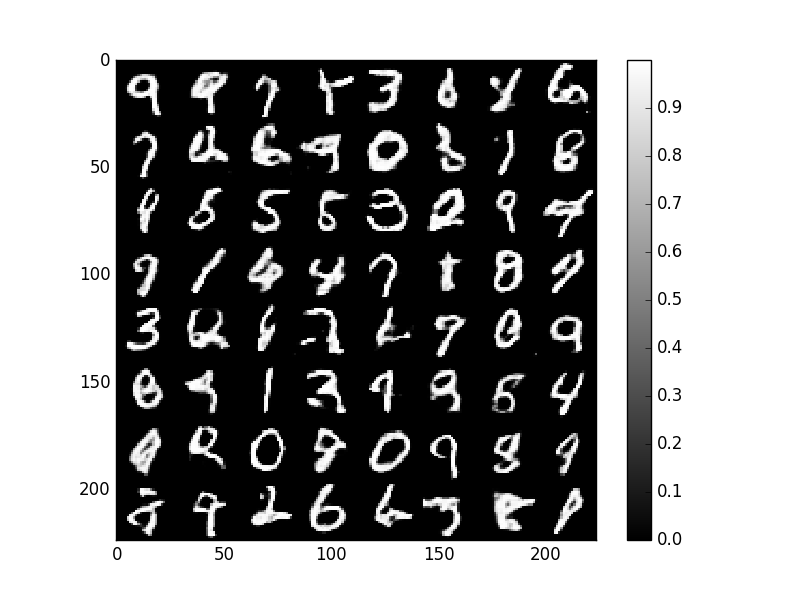

In [2]:
from IPython.display import Image
Image(filename='gan.png')